In [1]:
import numpy                                   as np
import pandas                                  as pd
import matplotlib.pyplot                      as plt
import                                        joblib
from sklearn.inspection    import partial_dependence
import                                            re
from scipy.interpolate               import interp1d  
import matplotlib                             as mpl
mpl.rcParams.update(            mpl.rcParamsDefault)
mpl.rcParams['mathtext.fontset']            = 'stix'
mpl.rcParams['font.family']          = 'STIXGeneral'

In [2]:
main_file             =             pd.read_excel('Supporting Dataset.xlsx')
main_file['ΔSOCSign'] = main_file['∆SOC'].apply(lambda x: 1 if x < 0 else 0)
df                    =                                   main_file.dropna()
df.iloc[:,:]

,Author,Year,Country,Site,Longitude,Latitude,MAT (Celsius),MAP (mm/yr),PET (mm/yr),AI (-),...,Sand%,pH,Initial Year,Duration (years),Final Year,Maximum depth (cm),"SOC stock-CT (0-30cm, MgC/ha)","SOC stock-NT (0-30cm, MgC/ha)",∆SOC,ΔSOCSign
0,Abreu,2011,U.S.,"Altus, Oklahoma",-99.33,34.64,15.0,741,1623.96,2.191579,...,75,5.8,2002,8,2010,110,37.9,38.3,0.35,0
1,Abreu,2011,U.S.,"Altus, Oklahoma",-99.33,34.64,15.0,741,1623.96,2.191579,...,75,5.8,2002,8,2010,110,38.9,39.4,0.50,0
2,Abreu,2011,U.S.,"Altus, Oklahoma",-99.33,34.64,15.0,741,1623.96,2.191579,...,75,5.8,2002,8,2010,110,39.3,44.0,4.76,0
3,Abreu,2011,U.S.,"Altus, Oklahoma",-99.33,34.64,15.0,741,1623.96,2.191579,...,75,5.8,2002,8,2010,110,39.2,38.9,-0.24,1
4,Abreu,2011,U.S.,"Altus, Oklahoma",-99.33,34.64,15.0,741,1623.96,2.191579,...,75,5.8,2002,8,2010,110,37.1,44.1,7.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Zhang et al.,2009,China,"Zhangwu, Liaoning",122.33,42.53,7.2,510,970.20,1.902353,...,79,7.8,2002,6,2008,100,40.2,49.7,9.53,0
146,Zhang et al.,2018,China,Jilin,125.60,44.20,4.4,520,845.76,1.626462,...,28,6.8,2001,12,2013,30,66.2,67.0,0.84,0
147,Zhang et al.,2018,China,Jilin,125.60,44.20,4.4,520,845.76,1.626462,...,28,6.8,2001,12,2013,30,68.1,73.4,5.29,0
148,Zibilske et al.,2002,U.S.,"Weslaco, Texas",-97.95,26.15,23.1,603,1617.36,2.682189,...,56,7.9,1992,9,2001,30,44.9,46.8,1.84,0


In [3]:
Xo = df.iloc[:, list(range(9,10)) + list(range(11,16)) + list(range(17,18)) + list(range(19,21))]
yo =                                                                                df.iloc[:,-1]
model  =                                                joblib.load('RF_BORDERLINE_SMOTE.joblib')
Xt     =                                                                       np.load('X_t.npy')
X      =                                                pd.DataFrame(data=Xt, columns=Xo.columns)

In [4]:
def perturb_data(X, uncertainty_ranges):
    X_perturbed = X.copy()
    for feature, (lower, upper) in uncertainty_ranges.items():
        range_width = X[feature].max() - X[feature].min()
        lower_bound = X[feature]    - range_width * lower
        upper_bound = X[feature]    + range_width * upper
        X_perturbed[feature] = np.random.uniform(lower_bound, upper_bound, size=len(X))

    return X_perturbed

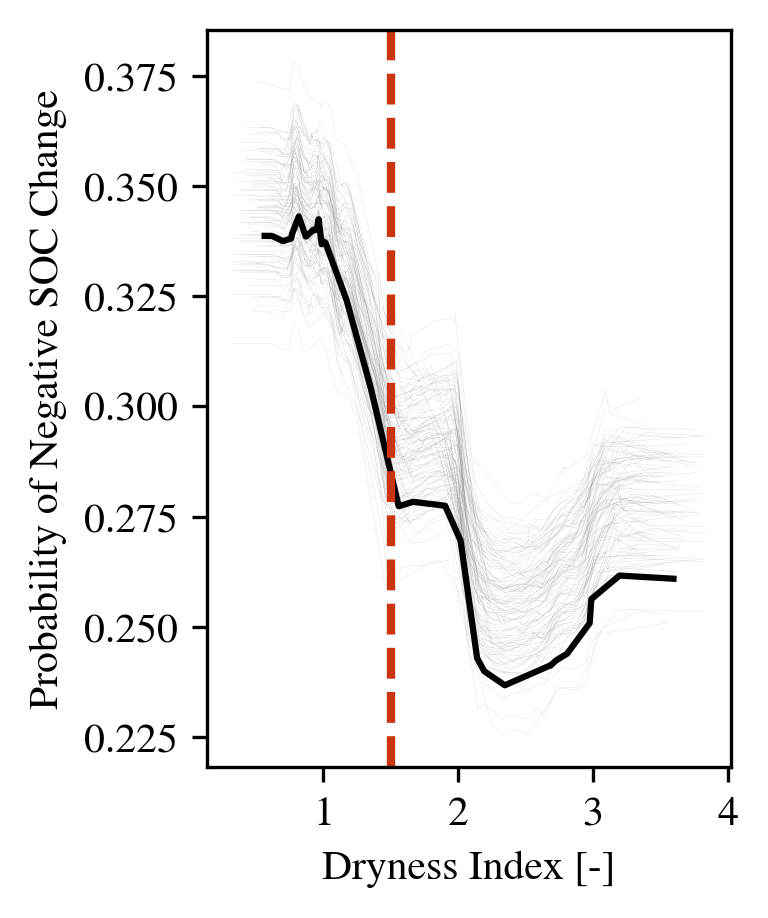

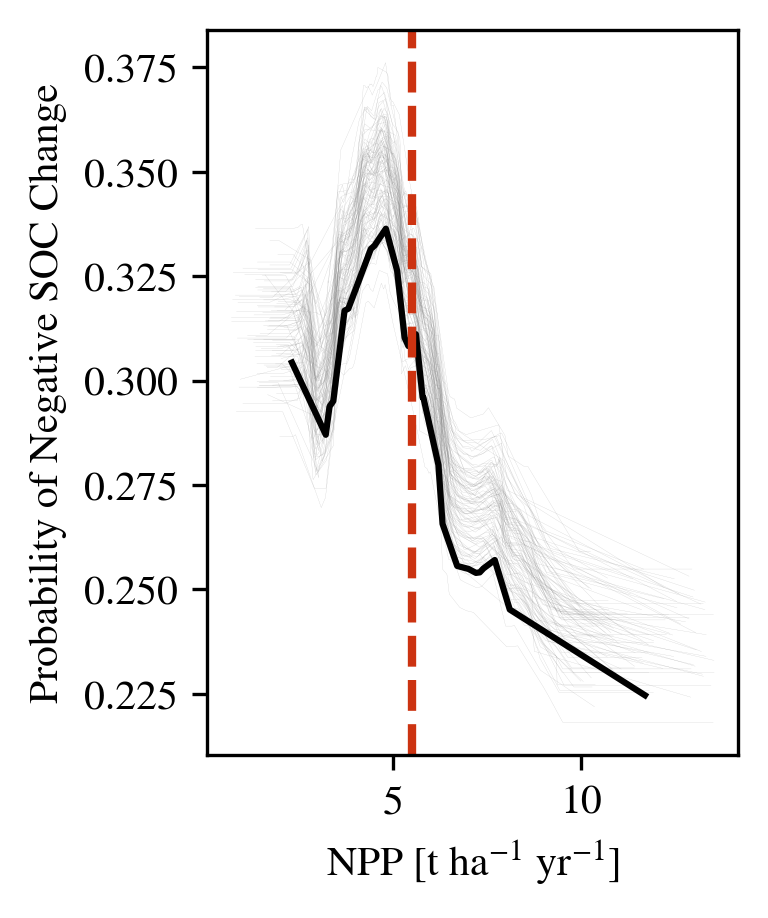

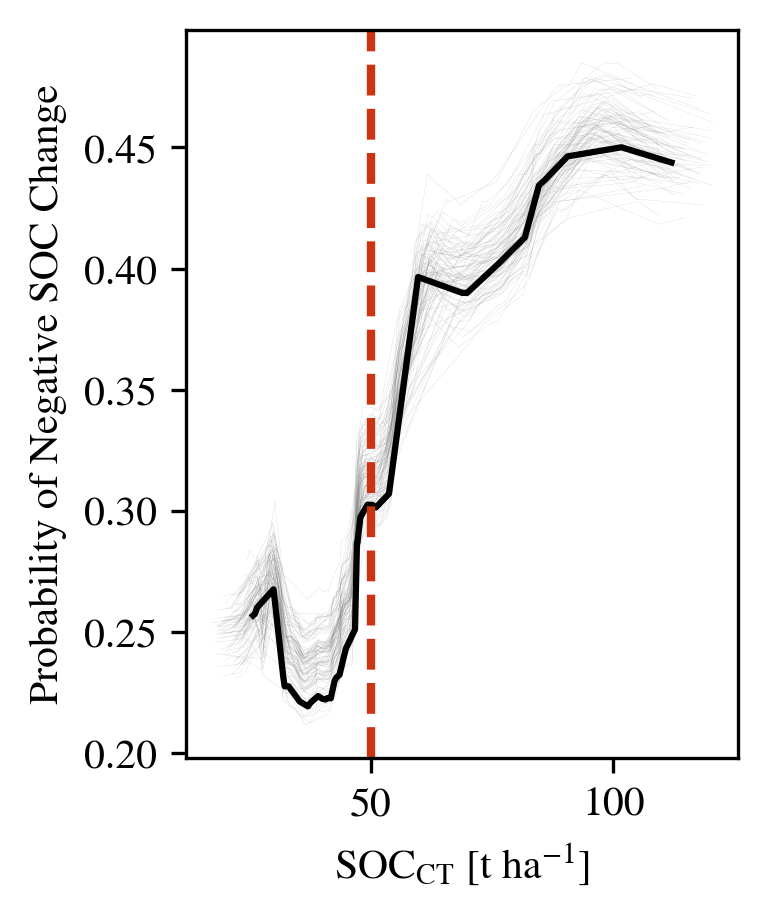

In [5]:
def plot_visual_ensemble(model, X, features, uncertainty_ranges, feature_labels, vertical_line_positions, other_uncertainty=0.1, n_perturbations=100):
    all_features = list(X.columns)
    for feature, label, line_pos in zip(features, feature_labels, vertical_line_positions):
        fig = plt.figure(figsize=(2.5, 3), dpi=300)

        for i in range(n_perturbations):
            X_perturbed = X.copy()
            for f, (lower, upper) in uncertainty_ranges.items():
                range_width = X.loc[:, f].max() - X.loc[:, f].min()
                lower_bound = X.loc[:, f] - range_width * lower
                upper_bound = X.loc[:, f] + range_width * upper
                X_perturbed.loc[:, f] = np.random.uniform(lower_bound, upper_bound, size=len(X))
            remaining_features = [f for f in all_features if f not in features]

            for rf in remaining_features:
                range_width = X.loc[:, rf].max() - X.loc[:, rf].min()
                lower_bound = X.loc[:, rf] - range_width * other_uncertainty
                upper_bound = X.loc[:, rf] + range_width * other_uncertainty
                X_perturbed.loc[:, rf] = np.random.uniform(lower_bound, upper_bound, size=len(X))
            pdp_results = partial_dependence(model, X_perturbed, features=[feature])
            plt.plot(pdp_results['grid_values'][0], pdp_results['average'][0], alpha=0.5, color='grey', lw = 0.05)

        pdp_results = partial_dependence(model, X, features=[feature])
        plt.plot(pdp_results['grid_values'][0], 1.02*pdp_results['average'][0], color='k', linewidth=1.5, label=f"Average PDP ({label})")

        plt.xlabel(label)  # Use the label directly
        plt.ylabel("Probability of Negative SOC Change")
        plt.axvline(x=line_pos, lw=2, color='#cc3311', linestyle='dashed')

        # Improved tight layout for better spacing
        plt.tight_layout(pad=0.5)  # Adjust padding as needed

        safe_feature_name = re.sub(r'[^\w\s-]', '', feature).replace(' ', '_')
        filename = f"visual_ensemble_{safe_feature_name}.png"
        fig.savefig(filename, transparent=True, dpi=300)
        plt.show()
        plt.close()

features_to_plot = ['AI (-)','NPP (t/ha/yr)', 'SOC stock-CT (0-30cm, MgC/ha)']

# Correct way to include LaTeX formatting in labels:
feature_labels = [r'Dryness Index [-]', r'NPP [t ha$^{-1}$ yr$^{-1}$]', r'$\mathrm{SOC}_{\mathrm{CT}}$ [t ha$^{-1}$]']

uncertainty_ranges      = {'AI (-)': (0.083, 0.083), 'NPP (t/ha/yr)': (0.2, 0.2), 'SOC stock-CT (0-30cm, MgC/ha)': (0.1, 0.1)}
vertical_line_positions = [1.5, 5.5, 50]

plot_visual_ensemble(model, X, features_to_plot, uncertainty_ranges, feature_labels, vertical_line_positions, other_uncertainty = 0.1)